In [2]:
# Just take all width for viz if you have a wide screen like me.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Use findspark to set Pyspark in sys.path
import findspark
findspark.init()

# import pyspark dependencies
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Window

import os

In [3]:
spark = SparkSession \
    .builder \
    .master('local[*]') \
    .config("spark.driver.memory", "10g") \
    .appName("steam-analysis-eda") \
    .getOrCreate()

In [92]:
%%bash
# Just a cell to allow bash interactions without bash in webui

git add . && git commit -m "compare arstechnica and steam-dataset computed owners" && git push origin main

[main a981db2] compare arstechnica and steam-dataset computed owners
 5 files changed, 738 insertions(+), 6 deletions(-)
 create mode 100644 notebooks/.ipynb_checkpoints/Compare_datasets-checkpoint.ipynb
 create mode 100644 notebooks/.ipynb_checkpoints/Untitled-checkpoint.ipynb
 create mode 100644 notebooks/Compare_datasets.ipynb
 create mode 100644 notebooks/Untitled.ipynb


To github.com:lheuveline/steam-analysis.git
   4d6e787..a981db2  main -> main


In [4]:
spark

In [14]:
dataset_path = os.path.join(os.path.dirname(os.path.realpath("")), "data/")

ars_dataset = "arstechnica/arstechnica_games_sales_1.csv"
ars_dataset_schema = StructType([
    StructField('#', IntegerType()),
    StructField('appid', IntegerType()),
    StructField('title', StringType()),
    StructField('release', DateType()),
    StructField('players', IntegerType()),
    StructField('owners', IntegerType()),
    StructField('total_hours', StringType()),
    StructField('developer', StringType()),
    StructField('publisher', StringType())
])

ars_df = spark.read.csv("file://" + dataset_path + base_dataset, header = True, schema = base_dataset_schema)

In [15]:
ars_df.show()

+---+------+--------------------+-------+-------+--------+-----------+--------------------+--------------------+
|  #| appid|               title|release|players|  owners|total_hours|           developer|           publisher|
+---+------+--------------------+-------+-------+--------+-----------+--------------------+--------------------+
|  1|304930|            Unturned|   null|9099669|12226095|  100073000|       Nelson Sexton|Smartly Dressed G...|
|  2|301520|           Robocraft|   null|3549730| 5344712|   56569900|             Freejam|             Freejam|
|  3|227940|   Heroes & Generals|   null|2779196| 4442318|   22875900|           Reto-Moto|           Reto-Moto|
|  4|208090|             Loadout|   null|1993110| 3312720|   17126300|     Edge of Reality|     Edge of Reality|
|  5|222900|Dead Island: Epid...|   null|1713161| 3900679|    7806700|    Stunlock Studios|         Deep Silver|
|  6|314060|Counter-Strike Ne...|   null|1439637| 2674384|   12633200|               Nexon|Nexon

In [22]:
steam_df = spark.read.parquet("file://" + dataset_path + "steam-dataset/steam_analysis.Games_Daily")
print('Base dataset schema :')
steam_df.printSchema()

steam_df = steam_df \
    .groupby('appid') \
    .count() \
    .sort(F.col('count').desc())

Base dataset schema :
root
 |-- steamid: decimal(20,0) (nullable = true)
 |-- appid: long (nullable = true)
 |-- playtime_2weeks: long (nullable = true)
 |-- playtime_forever: long (nullable = true)
 |-- dateretrieved: timestamp (nullable = true)



Corr: 0.8470632906074657


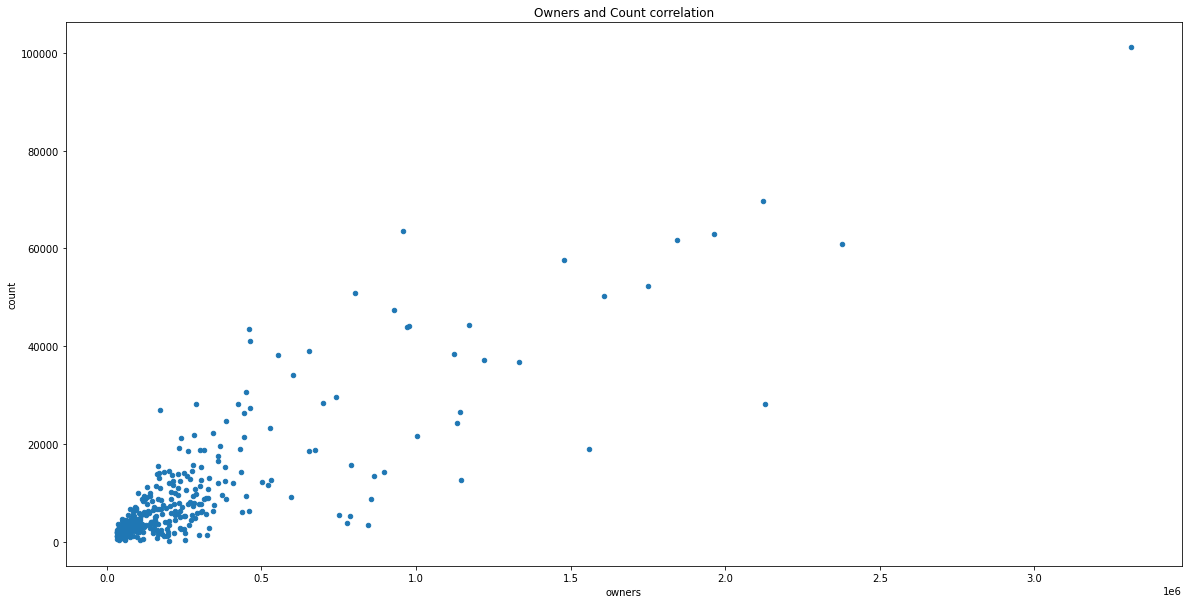

In [89]:
ars_steam_pddf = ars_df \
    .join(steam_df, on = ['appid']) \
    .select('appid', 'title', 'players', 'owners', 'total_hours', 'count') \
    .toPandas()

owners_quantile_1 = ars_steam_pddf['owners'].quantile(0.01)
owners_quantile_9 = ars_steam_pddf['owners'].quantile(0.99)

count_quantile_1 = ars_steam_pddf['count'].quantile(0.01)
count_quantile_9 = ars_steam_pddf['count'].quantile(0.99)


# Apply cleaning filters
clean_df = ars_steam_pddf \
    .loc[ars_steam_pddf['owners'] <= owners_quantile_9] \
    .loc[ars_steam_pddf['count'] <= count_quantile_9] \
    .loc[ars_steam_pddf['owners'] >= owners_quantile_1] \
    .loc[ars_steam_pddf['count'] >= count_quantile_1]

clean_df.plot.scatter(x = 'owners', y = 'count', figsize = (20, 10), title = "Owners and Count correlation")
print('Corr:', clean_df.corr()['owners']['count'])

In [56]:
import numpy as np

np.mean(np.sqrt(clean_df.owners - clean_df['count']) ** 2)

272444.4868035191

RMSE : 0.044881811759729544


/home/neadex/steam-analysis/venv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,appid,players,owners,count,scaled_count,scaled_owners
count,341.000000,3.410000e+02,3.410000e+02,341.000000,341.000000,341.000000
mean,261997.653959,1.779019e+05,2.822445e+05,9800.055718,0.095994,0.076434
std,36777.702561,2.490084e+05,3.932509e+05,13002.456930,0.128542,0.119847
min,10270.000000,2.434300e+04,3.144300e+04,90.000000,0.000000,0.000000
25%,244430.000000,4.293900e+04,7.505900e+04,2793.000000,0.026722,0.013292
50%,263620.000000,8.858300e+04,1.609360e+05,5279.000000,0.051299,0.039464
75%,286100.000000,1.852800e+05,2.978680e+05,11088.000000,0.108726,0.081196
max,329020.000000,1.993110e+06,3.312720e+06,101243.000000,1.000000,1.000000


<AxesSubplot:title={'center':'Scaled count and scaled owners KDE plot'}, ylabel='Density'>

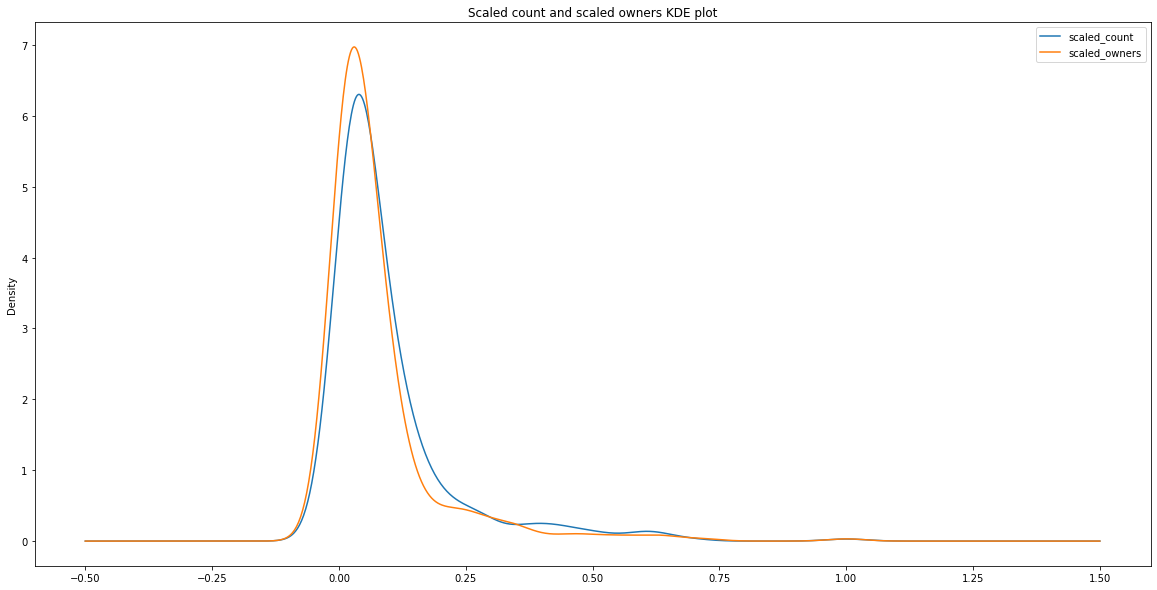

In [91]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
clean_df['scaled_count'] = scaler.fit_transform(clean_df['count'].values.reshape(-1, 1))
clean_df['scaled_owners'] = scaler.fit_transform(clean_df['owners'].values.reshape(-1, 1))

print("RMSE :", np.mean(np.sqrt(clean_df.scaled_count - clean_df.scaled_owners) ** 2))

display(clean_df.describe())

clean_df['scaled_count'].plot.kde(figsize=(20, 10), legend = True, title = "Scaled count and scaled owners KDE plot")
clean_df['scaled_owners'].plot.kde(legend = True)